# DeepONet Tutorial in PyTorch

This notebook is a PyTorch reimplementation of a simple 1D DeepONet originally written in JAX/Equinox.
It learns the antiderivative operator from pairs $(u(x), x)$ to $\int_0^x u(s) ds$ using the aligned dataset from DeepXDE.

**What changes vs JAX version**
- Uses `torch.nn` modules for the branch/trunk MLPs and a learnable scalar bias.
- Uses `torch.optim.Adam` with a standard manual training loop.
- Replaces `jax.vmap` with batched tensor operations.
- Keeps plots and evaluation identical where possible.


A DeepONet is a deep learning architecture to evaluate a *nonlinear operator*
applied to a discretized input field/function at an arbitrary query point. This
can, for instance, be used to learn solutions to a family of parametric PDEs
which can then be queried at arbitrary points in space (and time).

Examples of operator mappings:

* From initial condition to solution field at a later time
* From the parameter field (e.g. space-dependent diffusion coefficient) to the
  solution field

The DeepONet does not return the full output field, but allows us to query it at
arbitrary points.

Following the tutorial of
[DeepXDE](https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html),
this video is concered with **learning the 1d antiderivative operator**, defined by the ODE

$$
\begin{cases}
\frac{d v}{d x} &= u(x) \quad & x \in [0, 1]
\\
v(0) &= 0
\end{cases}
$$

For this, we discretize the domain $\Omega = [0, 1]$ into $m=100$ degrees of
freedom at which we evaluate $u(x)$. Then, the DeepONet $G_\theta$ takes this
$100$-dimensional vector and a one-dimensional query coordinate to evaluate
$v(x)$ at this query point.

$$
\begin{aligned}
G_\theta : \R^m \times \R^1 \mapsto \R
\end{aligned}
$$

![deeponet_architecture](deeponet_architecture.png)

In [1]:

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

# Prefer CUDA if available, else MPS (Apple Silicon), else CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device


/var/folders/sq/hv1_dwz10cx9mcwy54fj3st40000gn/T/ipykernel_79183/2134171055.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


device(type='mps')

In [3]:

# Dataset courtesy of DeepXDE (Lu et al.).
# Original JAX notebook downloaded from ETH Zurich course materials.
# We'll fetch the same training/test sets used there.
#!wget -q -O antiderivative_aligned_train.npz https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_train.npz
#!wget -q -O antiderivative_aligned_test.npz  https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_test.npz

train_npz = np.load("antiderivative_aligned_train.npz", allow_pickle=True)
test_npz  = np.load("antiderivative_aligned_test.npz", allow_pickle=True)

branch_inputs_train = train_npz["X"][0]   # (N_train, in_size_branch)
trunk_inputs_train  = train_npz["X"][1]   # (N_train, N_grid, 1)
outputs_train       = train_npz["y"]      # (N_train, N_grid, 1)

branch_inputs_test = test_npz["X"][0]
trunk_inputs_test  = test_npz["X"][1]
outputs_test       = test_npz["y"]

branch_inputs_train.shape, trunk_inputs_train.shape, outputs_train.shape


((1200, 1000), (1000, 1), (1200, 1000))

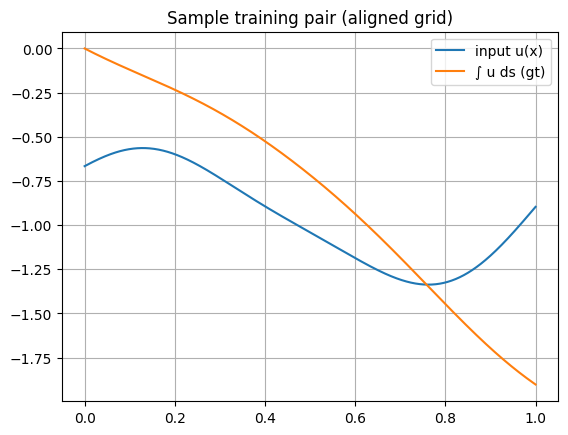

In [4]:

f_idx=2 #index of the function to plot
plt.plot(trunk_inputs_train[:, 0], branch_inputs_train[f_idx, :], label="input u(x)")
plt.plot(trunk_inputs_train[:, 0], outputs_train[f_idx, :], label="∫ u ds (gt)")
plt.grid()
plt.legend()
plt.title("Sample training pair (aligned grid)")
plt.show()


In [7]:
class MLP(nn.Module):
    def __init__(self, in_size, out_size, width_size, depth, activation=nn.ReLU):
        super().__init__()
        layers = []
        last = in_size
        for _ in range(depth):
            layers.append(nn.Linear(last, width_size))
            layers.append(activation())
            last = width_size
        layers.append(nn.Linear(last, out_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class DeepONet1dSep(nn.Module):
    def __init__(
        self,
        in_size_branch: int,
        interact_size: int,            # P' must match for branch & trunk
        # branch hyperparams
        branch_width: int = 40,
        branch_depth: int = 2,
        branch_activation: nn.Module = nn.ReLU,
        # trunk hyperparams
        trunk_input_dim: int = 1,
        trunk_width: int = 40,
        trunk_depth: int = 2,
        trunk_activation: nn.Module = nn.Tanh,  # smoothness w.r.t. x
    ):
        super().__init__()
        self.branch_net = MLP(
            in_size=in_size_branch,
            out_size=interact_size,
            width_size=branch_width,
            depth=branch_depth,
            activation=branch_activation,
        )
        self.trunk_net = MLP(
            in_size=trunk_input_dim,
            out_size=interact_size,
            width_size=trunk_width,
            depth=trunk_depth,
            activation=trunk_activation,
        )
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x_branch, x_trunk):
        """
        x_branch: (B, P) or (P,)
        x_trunk:  (N,1) or (B, N) or (B, N, 1)
        returns:  (B, N, 1) or (N, 1) if single-sample
        """
        single_sample = False
        if x_branch.dim() == 1:
            x_branch = x_branch.unsqueeze(0)  # (1, P)
            single_sample = True

        # Normalize x_trunk to (B, N, 1)
        if x_trunk.dim() == 1:
            x_trunk = x_trunk.unsqueeze(-1)                # (N,) -> (N,1)
        if x_trunk.dim() == 2:
            if x_trunk.size(-1) != 1:                      # (B,N) -> (B,N,1)
                x_trunk = x_trunk.unsqueeze(-1)
            else:                                          # (N,1) -> (B,N,1)
                x_trunk = x_trunk.unsqueeze(0).expand(x_branch.size(0), -1, -1)
        elif x_trunk.dim() == 3 and x_trunk.size(0) == 1 and x_branch.size(0) > 1:
            x_trunk = x_trunk.expand(x_branch.size(0), -1, -1)

        B, N, _ = x_trunk.shape
        bfeat = self.branch_net(x_branch)                        # (B, P')
        tfeat = self.trunk_net(x_trunk.reshape(B * N, -1))       # (B*N, P')
        tfeat = tfeat.view(B, N, -1)                             # (B, N, P')
        out = (bfeat.unsqueeze(1) * tfeat).sum(dim=-1, keepdim=True) + self.bias.view(1, 1, 1)
        if single_sample:
            out = out.squeeze(0)  # (N,1)
        return out


In [8]:

# Infer sizes from data
in_size_branch = branch_inputs_train.shape[1]
N_grid = trunk_inputs_train.shape[1]

"""
model = DeepONet1d(
    in_size_branch=in_size_branch,
    width_size=40,
    depth=1,
    interact_size=40,
    branch_activation=nn.ReLU,   # branch stays ReLU
    trunk_activation=nn.ReLU     # trunk is smooth
).to(device)
"""
#Let's try to add more hidden layers
#TRY DIFFERENT ACTIVATION FUNCTIONS !!!!!!!!!!  -> FARE GRID SEARCH SU ARCHITETTURA
model = DeepONet1dSep(
    in_size_branch=in_size_branch,
    interact_size=20,          # (p in the Lu Lu article) must match between branch & trunk outputs
    branch_width=40,
    branch_depth=2,
    branch_activation=nn.ReLU, # piecewise-linear is fine for u-sensors
    trunk_input_dim=1,
    trunk_width=40,
    trunk_depth=3,
    trunk_activation=nn.ReLU   # smoother w.r.t. x
).to(device)


# Torch tensors
Xb_train = torch.tensor(branch_inputs_train, dtype=torch.float32, device=device)
Xt_train = torch.tensor(trunk_inputs_train,  dtype=torch.float32, device=device)
Y_train  = torch.tensor(outputs_train,       dtype=torch.float32, device=device)

Xb_test = torch.tensor(branch_inputs_test, dtype=torch.float32, device=device)
Xt_test = torch.tensor(trunk_inputs_test,  dtype=torch.float32, device=device)
Y_test  = torch.tensor(outputs_test,       dtype=torch.float32, device=device)

# Ensure Y has shape (B, N, 1)
if Y_train.dim() == 2:
    Y_train = Y_train.unsqueeze(-1)
if Y_test.dim() == 2:
    Y_test = Y_test.unsqueeze(-1)


Xb_train.shape, Xt_train.shape, Y_train.shape, Xb_test.shape


(torch.Size([1200, 1000]),
 torch.Size([1000, 1]),
 torch.Size([1200, 1000, 1]),
 torch.Size([300, 1000]))

In [ ]:

optimizer = optim.Adam(model.parameters(), lr=1e-3)

def mse_loss(pred, target):
    return torch.mean((pred - target) ** 2)

loss_history = []
model.train()
num_steps = 20_000
for _ in tqdm(range(num_steps)):
    optimizer.zero_grad(set_to_none=True)
    pred = model(Xb_train, Xt_train)           # (B, N, 1)
    loss = mse_loss(pred, Y_train)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.detach().cpu().item())

plt.plot(loss_history[100:]) #We remove the first 100 steps to better visualize the trend
plt.xlabel("Step")
plt.ylabel("MSE loss")
plt.title("Training loss")
plt.grid()
plt.show()


  0%|          | 0/20000 [00:00<?, ?it/s]

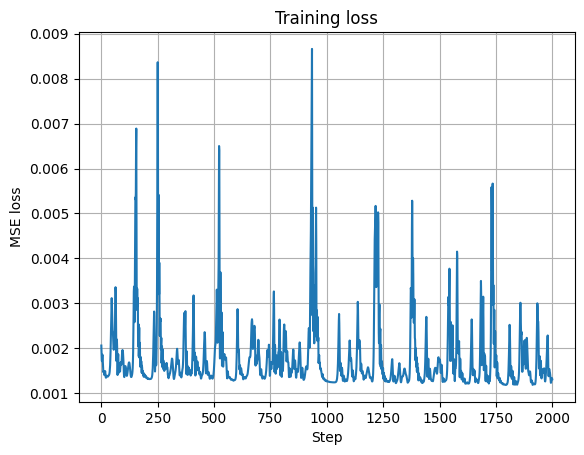

In [ ]:
#Zoom in
plt.plot(loss_history[18000:]) #We remove the first 18000 steps to better visualize the trend
plt.xlabel("Step")
plt.ylabel("MSE loss")
plt.title("Training loss")
plt.grid()
plt.show()


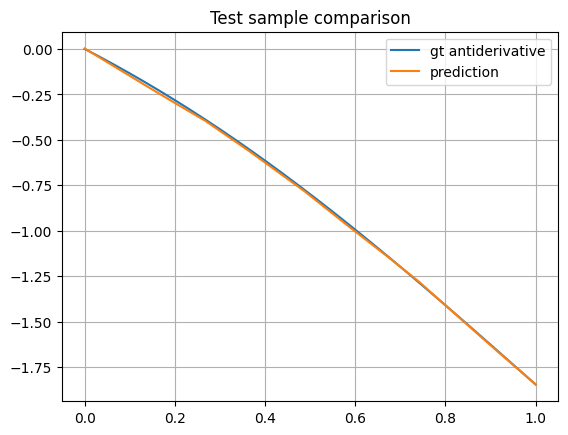

In [ ]:
model.eval()
with torch.no_grad():
    sample_idx = 10

    # Use shared trunk grid if Xt_test is 2D (N,1); otherwise pick sample
    if Xt_test.dim() == 2:              # (N, 1)
        xgrid_t = Xt_test               # (N, 1)
        y_pred  = model(Xb_test[sample_idx], xgrid_t)   # (N, 1)
        xgrid   = xgrid_t[:, 0].cpu().numpy()           # (N,)
    else:                                # (B, N, 1)
        xgrid_t = Xt_test[sample_idx]    # (N, 1)
        y_pred  = model(Xb_test[sample_idx], xgrid_t)   # (N, 1)
        xgrid   = xgrid_t[:, 0].cpu().numpy()           # (N,)

    # Y_test should be (B, N, 1). If it's (B, N), add the last dim.
    y_gt = Y_test[sample_idx]
    if y_gt.dim() == 1:                  # (N,) -> (N,1)
        y_gt = y_gt.unsqueeze(-1)

    plt.plot(xgrid, y_gt[:, 0].cpu().numpy(), label="gt antiderivative")
    plt.plot(xgrid, y_pred[:, 0].cpu().numpy(), label="prediction")
    plt.title("Test sample comparison")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:

def normalized_l2_error(pred, ref):
    # pred/ref: (...,)
    diff = pred - ref
    diff_norm = torch.linalg.vector_norm(diff)
    ref_norm  = torch.linalg.vector_norm(ref)
    return (diff_norm / ref_norm).item()

model.eval()
errs = []
with torch.no_grad():
    # Batch through the whole test set
    pred = model(Xb_test, Xt_test)  # (B, N, 1)
    for b in range(pred.shape[0]):
        e = normalized_l2_error(pred[b].view(-1), Y_test[b].view(-1))
        errs.append(e)

mean_err = float(np.mean(errs))
std_err  = float(np.std(errs))
mean_err, std_err


(0.033511702098573244, 0.036195881756732065)

## Test: predict new data

In [24]:
# ========= Evaluation config =========
data_path    = "antiderivative_aligned_data.npz"   # or ..._test.npz / ..._train.npz
weights_path = "deeponet.pt"                       # your saved model state_dict

"""
# Must match the trained model:
in_size_branch = 100
width_size     = 40
depth          = 1
interact_size  = 40

# What to plot
plot_sample_indices = [0, 1, 2]

# Device preference: CUDA > MPS (Apple Silicon) > CPU
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device
"""


'\n# Must match the trained model:\nin_size_branch = 100\nwidth_size     = 40\ndepth          = 1\ninteract_size  = 40\n\n# What to plot\nplot_sample_indices = [0, 1, 2]\n\n# Device preference: CUDA > MPS (Apple Silicon) > CPU\nimport torch\nif torch.cuda.is_available():\n    device = torch.device("cuda")\nelif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():\n    device = torch.device("mps")\nelse:\n    device = torch.device("cpu")\ndevice\n'

In [25]:
import numpy as np

npz = np.load(data_path, allow_pickle=True)
branch_inputs = npz["X"][0]    # (B, P)
trunk_inputs  = npz["X"][1]    # (N, 1) shared grid
y_true        = npz["y"]       # (B, N) or (B, N, 1)

print("Loaded shapes:", branch_inputs.shape, trunk_inputs.shape, y_true.shape)

# Ensure y_true is (B, N, 1)
if y_true.ndim == 2:
    y_true = y_true[..., None]
elif y_true.ndim == 3 and y_true.shape[-1] == 1:
    pass
else:
    raise ValueError(f"Unexpected y shape: {y_true.shape}")

import torch
Xb = torch.tensor(branch_inputs, dtype=torch.float32, device=device)   # (B, P)
Xt = torch.tensor(trunk_inputs,  dtype=torch.float32, device=device)   # (N, 1)
Y  = torch.tensor(y_true,        dtype=torch.float32, device=device)   # (B, N, 1)

# Expand shared trunk grid to batch: (B, N, 1)
Xt_batch = Xt.unsqueeze(0).expand(Xb.shape[0], -1, -1)


Loaded shapes: (150, 1000) (1000, 1) (150, 1000)


In [26]:
print("Xb shape:", Xb.shape)         # should be (B, P) only
print("Xt shape:", Xt.shape)         # (N, 1)
try:
    print("Xt_batch shape:", Xt_batch.shape)  # (B, N, 1)
except NameError:
    pass

# What the trained model expects
branch_in_expected = model.branch_net.net[0].in_features
trunk_in_expected  = model.trunk_net.net[0].in_features
print("Model expects: branch_in =", branch_in_expected, "  trunk_in =", trunk_in_expected)

# If you previously did something like: Xb = Xb.unsqueeze(1).expand(B,N,P) — undo it.
if Xb.ndim > 2:
    # collapse any extra dims except the last one (features)
    Xb = Xb.view(Xb.shape[0], -1)  # but better: rebuild from the original branch_inputs array
    print("Fixed Xb to shape:", Xb.shape)

# Xt should be shared grid: (N,1)
# Build Xt_batch for the model call as (B,N,1), but DO NOT touch Xb
Xt_batch = Xt.unsqueeze(0).expand(Xb.shape[0], -1, -1)
print("Xt_batch shape:", Xt_batch.shape)

import numpy as np
import torch

P_data = Xb.shape[1]
P_tgt  = branch_in_expected

if P_data != P_tgt:
    # assume branch and trunk share the same interval; infer from Xt
    a = float(Xt[0,0].cpu().item())
    b = float(Xt[-1,0].cpu().item())
    x_src = np.linspace(a, b, P_data)
    x_tgt = np.linspace(a, b, P_tgt)

    Xb_np = Xb.detach().cpu().numpy()
    Xb_rs = np.stack([np.interp(x_tgt, x_src, row) for row in Xb_np], axis=0)  # (B, P_tgt)
    Xb = torch.tensor(Xb_rs, dtype=torch.float32, device=Xb.device)
    print(f"Resampled branch from P={P_data} -> P={P_tgt}")


Xb shape: torch.Size([150, 1000])
Xt shape: torch.Size([1000, 1])
Xt_batch shape: torch.Size([150, 1000, 1])
Model expects: branch_in = 1000   trunk_in = 1
Xt_batch shape: torch.Size([150, 1000, 1])


In [27]:
import torch

def normalized_l2_error(pred, ref):
    diff = pred - ref
    diff_norm = torch.linalg.vector_norm(diff)
    ref_norm  = torch.linalg.vector_norm(ref)
    return (diff_norm / (ref_norm + 1e-12)).item()

with torch.no_grad():
    Y_pred = model(Xb, Xt_batch)   # (B, N, 1)

B, N, _ = Y.shape
errs, mses = [], []
for i in range(B):
    errs.append(normalized_l2_error(Y_pred[i].view(-1), Y[i].view(-1)))
    mses.append(torch.mean((Y_pred[i] - Y[i])**2).item())

import numpy as np
print(f"Mean norm L2 error: {np.mean(errs):.6e}  (std {np.std(errs):.6e})")
print(f"Mean MSE:           {np.mean(mses):.6e}  (std {np.std(mses):.6e})")

Mean norm L2 error: 9.656138e+00  (std 5.687068e+00)
Mean MSE:           4.078556e-01  (std 3.633204e-01)


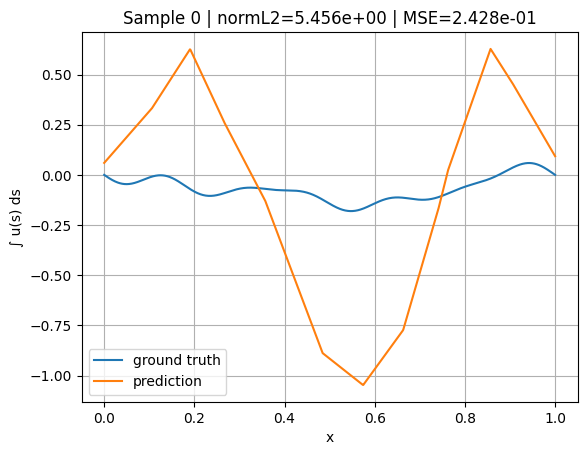

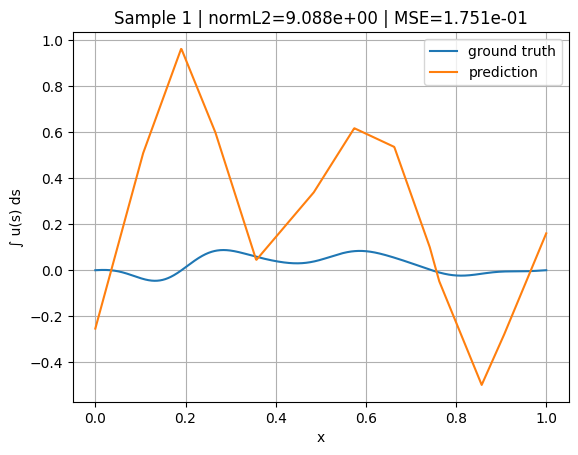

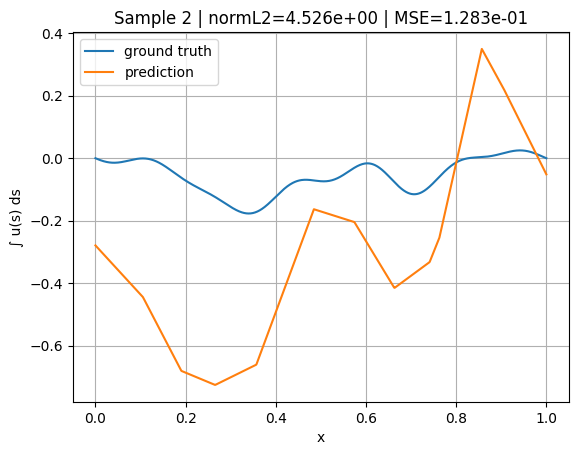

In [28]:
import matplotlib.pyplot as plt

xgrid = Xt[:, 0].detach().cpu().numpy()  # (N,)

plot_sample_indices = [0, 1, 2]

for idx in plot_sample_indices:
    if not (0 <= idx < B):
        continue
    y_gt  = Y[idx, :, 0].detach().cpu().numpy()
    y_hat = Y_pred[idx, :, 0].detach().cpu().numpy()
    plt.figure()
    plt.plot(xgrid, y_gt,  label="ground truth")
    plt.plot(xgrid, y_hat, label="prediction")
    plt.title(f"Sample {idx} | normL2={errs[idx]:.3e} | MSE={mses[idx]:.3e}")
    plt.xlabel("x"); plt.ylabel("∫ u(s) ds")
    plt.grid(); plt.legend()
    plt.show()
